In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
test_image = Image.open('clock_test_image_8x8.tif')
np_test_image = np.array(test_image)

test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append(pixel[0] / 256)

np_test_image_final = np.array(test_image_final)

np_test_image = np_test_image_final.reshape((8,8))
print(np_test_image)

[[0.734375   0.7890625  0.80859375 0.8203125  0.828125   0.81640625
  0.80859375 0.77734375]
 [0.79296875 0.859375   0.87109375 0.87890625 0.890625   0.90234375
  0.890625   0.859375  ]
 [0.84375    0.890625   0.89453125 0.90625    0.859375   0.6328125
  0.77734375 0.90234375]
 [0.86328125 0.8984375  0.8984375  0.91796875 0.7734375  0.31640625
  0.453125   0.94140625]
 [0.89453125 0.9375     0.91796875 0.91796875 0.8203125  0.26171875
  0.4375     0.96875   ]
 [0.68359375 0.51953125 0.6953125  0.953125   0.734375   0.3359375
  0.49609375 0.65625   ]
 [0.5625     0.5390625  0.52734375 0.99609375 0.4140625  0.16796875
  0.22265625 0.33203125]
 [0.61328125 0.6171875  0.71484375 0.90625    0.73046875 0.55859375
  0.5625     0.578125  ]]


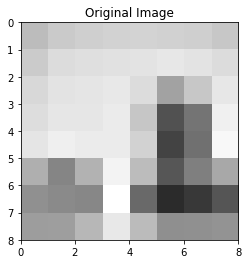

In [3]:
def plot_image8x8(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 8, 8, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image8x8(np_test_image, "Original Image")   

[[0.12184001 0.1309132  0.13415363 0.13609788 0.13739405 0.1354498
  0.13415363 0.12896894]
 [0.13156128 0.14257873 0.14452299 0.14581916 0.14776341 0.14970767
  0.14776341 0.14257873]
 [0.13998639 0.14776341 0.1484115  0.15035575 0.14257873 0.10498979
  0.12896894 0.14970767]
 [0.14322682 0.14905958 0.14905958 0.15230001 0.12832086 0.0524949
  0.07517788 0.15618852]
 [0.1484115  0.15554043 0.15230001 0.15230001 0.13609788 0.0434217
  0.07258554 0.16072512]
 [0.1134149  0.08619532 0.11535916 0.15813278 0.12184001 0.05573532
  0.08230681 0.1088783 ]
 [0.09332426 0.08943575 0.08749149 0.16526171 0.06869703 0.02786766
  0.03694085 0.05508724]
 [0.10174937 0.10239745 0.11859958 0.15035575 0.12119192 0.09267618
  0.09332426 0.0959166 ]]


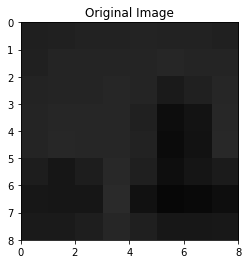

In [4]:
# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

def denormalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image    


np_test_image_normalized = normalize(np_test_image.reshape(64))
np_test_image_normalized = np_test_image_normalized.reshape((8,8))

print(np_test_image_normalized)

plot_image8x8(np_test_image_normalized, "Original Image")   

In [5]:
def ansatz(param, ansatz_num_layers):    
    num_q = 4
    qc = QuantumCircuit(num_q, num_q)    
    for ansatz_j in range(ansatz_num_layers):        
        for ansatz_i in range(num_q):
            qc.ry(param[ansatz_i + ansatz_j*num_q], ansatz_i)        
        if ansatz_j < ansatz_num_layers-1:            
            qc.cx(0,1)
            qc.cx(1,2)
            qc.cx(2,3)
            qc.cx(3,0)
    qc.barrier()
    qc.measure(range(num_q), range(num_q))      
    return qc

In [6]:

def loss_function(params, loss_num_layers, loss_num_shots):
    
    # We will optimize this quantity as well
    num_shots = loss_num_shots
    circ = ansatz(param=params, ansatz_num_layers=loss_num_layers)
    counts = execute(circ, backend=simulator, shots=num_shots).result().get_counts(circ)
    
    strings = []
    for loss_i in range(16):
        strings.append(get_bin(loss_i,4))
    
    for loss_i in strings:
        if loss_i not in counts:
            counts[loss_i] = 0
    
    p = [counts[string]/num_shots for string in strings]
    
    return sum([(p[loss_i] - np_test_image_normalized[loss_i])**2 for loss_i in range(len(np_test_image_normalized))])
    #return sum([abs(p[i] - prob_distr[i]) for i in range(len(prob_distr))])
    #return sum([ prob_distr[i]*math.log2(p[i]) for i in range(len(prob_distr))])

In [5]:
# Training the Quantum Circuit
import scipy.optimize as spo

In [13]:
np_test_image_normalized = np_test_image_normalized.reshape(16)

# Setting up the simulator:
simulator = Aer.get_backend('aer_simulator')
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)


# res = spo.minimize(loss_function, np.ones(4 * 5), args=(5,4000), method="COBYLA")
minim_kwargs = {"method":"COBYLA", "args":(10, 16000)}
res = spo.basinhopping(loss_function, np.ones(4 * 10), minimizer_kwargs=minim_kwargs, niter=100)

print(res.x)

[20.3894816  18.02273499 24.77451361 19.41226744 15.45411217 12.62740883
  6.89755627  7.60452333 12.69604778 11.32128826 11.15443358  7.60654981
  6.86593435  4.37483347  0.38375222  3.69661565  8.35885874 10.09129986
  6.13470835  6.59110081 -4.31010815  3.82455583  0.21096317  6.19635895
  4.81032818  1.41227066  7.36358347  2.3083785  -2.56166876  5.57765718
  1.1011375  -3.74781906  3.07562406  1.64802533  2.23487996  3.89649405
  2.73539976  2.30508499  1.40872258  3.53107343]


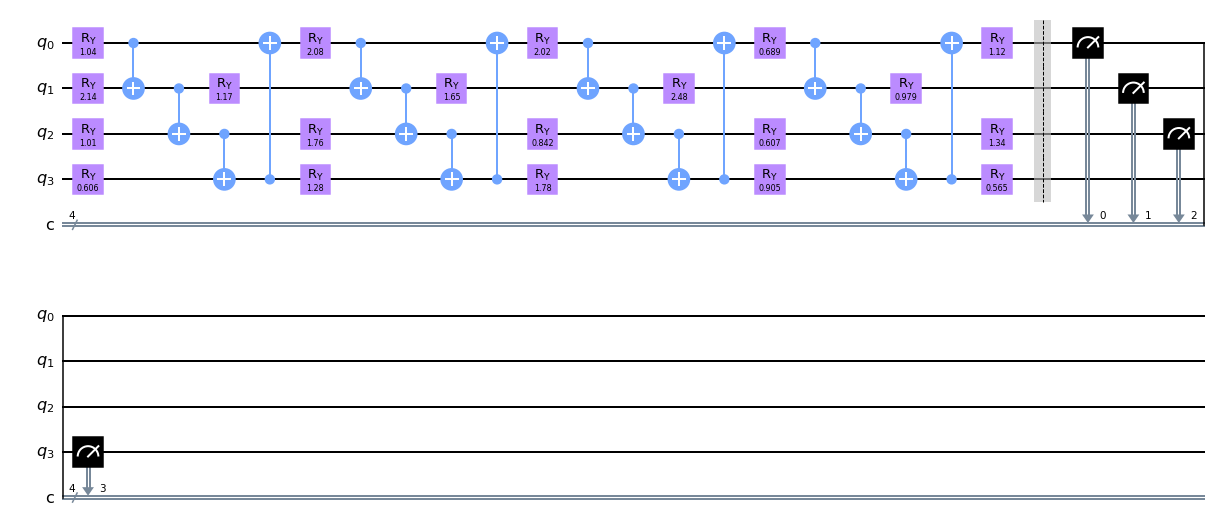

In [9]:
optimized_params = res.x

trained_ansatz = ansatz(optimized_params, 5)

trained_ansatz.draw()

In [10]:
simulator = Aer.get_backend('aer_simulator')
trained_ansatz_transpiled = transpile(trained_ansatz, simulator)

# Run and get statevector
result = simulator.run(trained_ansatz_transpiled).result()
counts = result.get_counts()

print(counts)

{'1110': 1, '0100': 235, '1111': 58, '0001': 141, '0000': 259, '0010': 19, '1101': 9, '1100': 47, '0110': 96, '1000': 6, '1010': 68, '1001': 4, '0101': 62, '1011': 19}


[[0.50292115 0.37107319 0.13621559 0.        ]
 [0.47905343 0.24606275 0.30618622 0.        ]
 [0.07654655 0.0625     0.2576941  0.13621559]
 [0.21423921 0.09375    0.03125    0.23799291]]


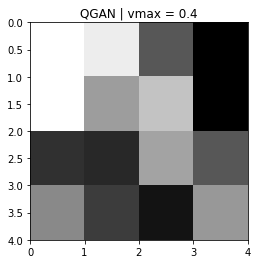

In [12]:
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

qGAN_output = []
for i in range(16):
    if get_bin(i, 4) in counts:
        qGAN_output.append(np.sqrt( ( counts.get(get_bin(i, 4)) / 16000 ) ) )
    else:
        qGAN_output.append(0)
        
np_qGAN_output = np.array(qGAN_output).reshape((4,4))
np_qGAN_output = normalize(np_qGAN_output)

print(np_qGAN_output)

plot_image4x4_bright(np_qGAN_output, "QGAN | vmax = 0.4")   

In [21]:
# We want to quantify error
# Let's calculate the RMSE for our simulator output:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

In [23]:
print(np_test_image[1][1])
print(np_test_image_normalized)
test = un_normalize(np_test_image, np_test_image_normalized, np_test_image_normalized, 4)

0.89453125
[0.2778443  0.2898664  0.29520956 0.29120219 0.3032243  0.30589588
 0.07614002 0.30723167 0.09884845 0.30456009 0.16964532 0.30723167
 0.14827268 0.30589588 0.1322432  0.14960847]
Traceback (most recent call last):
  Input In [23] in <cell line: 3>
    test = un_normalize(np_test_image, np_test_image_normalized, np_test_image_normalized, 4)
  Input In [21] in un_normalize
    normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
IndexError: invalid index to scalar variable.

Use %tb to get the full traceback.


In [24]:
rmse_error = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized.reshape((4,4)), np_qGAN_output, 4), 4)
print(rmse_error)

0.04503581547783959


In [6]:
import time
import datetime

print(time.time())
print(datetime.datetime.now() + datetime.timedelta(hours=5.5))

1670689150.3134966
2022-12-10 21:49:10.313564


num_layers =  1
Beginning Training @  2022-12-07 14:07:31.507067
Finished Training @  2022-12-07 14:10:50.657413
Time Elapsed:  199.1503472328186 s.


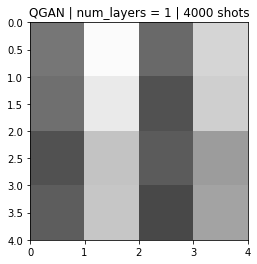

-X-X-X-X-X-X-X-
num_layers =  2
Beginning Training @  2022-12-07 14:10:51.039180
Finished Training @  2022-12-07 14:18:51.286365
Time Elapsed:  480.24718499183655 s.


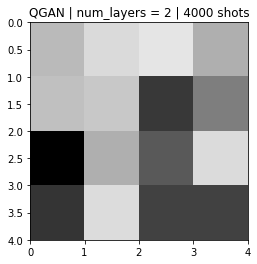

-X-X-X-X-X-X-X-
num_layers =  3
Beginning Training @  2022-12-07 14:18:51.500366
Finished Training @  2022-12-07 14:30:03.234070
Time Elapsed:  671.7337040901184 s.


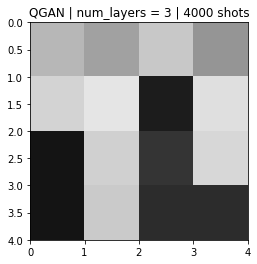

-X-X-X-X-X-X-X-
num_layers =  4
Beginning Training @  2022-12-07 14:30:03.437048
Finished Training @  2022-12-07 14:45:42.919042
Time Elapsed:  939.4819917678833 s.


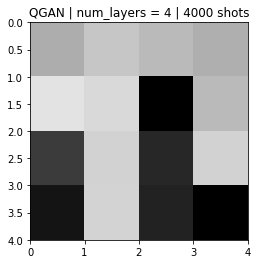

-X-X-X-X-X-X-X-
num_layers =  5
Beginning Training @  2022-12-07 14:45:43.305337
Finished Training @  2022-12-07 15:09:43.634722
Time Elapsed:  1440.3293855190277 s.


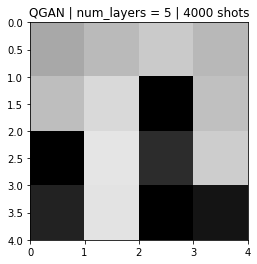

-X-X-X-X-X-X-X-
num_layers =  6
Beginning Training @  2022-12-07 15:09:43.917110
Finished Training @  2022-12-07 15:34:41.377285
Time Elapsed:  1497.460171699524 s.


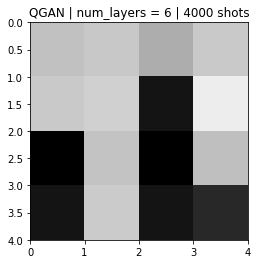

-X-X-X-X-X-X-X-
num_layers =  7
Beginning Training @  2022-12-07 15:34:41.590688
Finished Training @  2022-12-07 17:34:50.836233
Time Elapsed:  2714.171865940094 s.


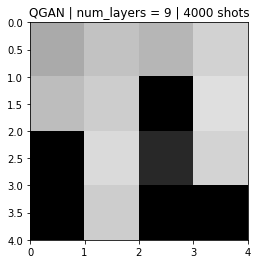

-X-X-X-X-X-X-X-
num_layers =  10
Beginning Training @  2022-12-07 17:34:51.090679


In [ ]:
num_layers_array = [1,2,3,4,5,6,7,8,9,10]
num_shots_array = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

# Setting up the simulator:
simulator = Aer.get_backend('aer_simulator')
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

#Let's see how number of layers affects the image output
num_layers_array_rmse_error = []
for num_layers_value in num_layers_array:
    print("num_layers = ", num_layers_value)
    # Define and Train the QGAN
    start_time = time.time()
    print("Beginning Training @ ", (datetime.datetime.now() + datetime.timedelta(hours=5.5)))
    # res = spo.minimize(loss_function, np.ones(4 * num_layers_value), args=(num_layers_value, 4000), method="COBYLA")
    minim_kwargs = {"method":"COBYLA", "args":(num_layers_value, 4000)}
    res = spo.basinhopping(loss_function, np.ones(4 * num_layers_value), minimizer_kwargs=minim_kwargs, niter=100)
    end_time = time.time()
    print("Finished Training @ ", (datetime.datetime.now() + datetime.timedelta(hours=5.5)))
    print("Time Elapsed: ", (end_time - start_time), "s.")
    optimized_params = res.x
    trained_ansatz = ansatz(optimized_params, num_layers_value)
    
    # Run the QGAN
    trained_ansatz_transpiled = transpile(trained_ansatz, simulator)
    result = simulator.run(trained_ansatz_transpiled).result()
    counts = result.get_counts()
    
    # Construct the image from QGAN circuit output
    qGAN_output = []
    for i in range(16):
        if get_bin(i, 4) in counts:
            qGAN_output.append(np.sqrt( ( counts.get(get_bin(i, 4)) / 4000 ) ) )
        else:
            qGAN_output.append(0)
        
    np_qGAN_output = np.array(qGAN_output).reshape((4,4))
    np_qGAN_output = normalize(np_qGAN_output)
    
    # Print image output
    title_string = "QGAN | num_layers = {} | 4000 shots".format(num_layers_value)
    plot_image4x4_bright(np_qGAN_output, title_string)

    # Calculate error
    rmse_error = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized.reshape((4,4)), np_qGAN_output, 4), 4)
    num_layers_array_rmse_error.append(rmse_error)
    
    print("-X-X-X-X-X-X-X-")
    
print(num_layers_array_rmse_error)

In [ ]:
# RMSE Error isn't really effective in determining how well increasing the number of layers leads to a better iamge
# We'll do this for a 8x8 image and use SSIM to get a better idea of how similar the images are

In [2]:
test_image_8x8 = Image.open('clock_test_image_8x8.tif')
np_test_image_8x8 = np.array(test_image_8x8)

test_image_8x8_final = []
for row in np_test_image_8x8:
    for pixel in row:
        test_image_8x8_final.append(pixel[0] / 256)

np_test_image_8x8_final = np.array(test_image_8x8_final)

np_test_image_8x8 = np_test_image_8x8_final.reshape((8,8))
print(np_test_image_8x8)

[[0.734375   0.7890625  0.80859375 0.8203125  0.828125   0.81640625
  0.80859375 0.77734375]
 [0.79296875 0.859375   0.87109375 0.87890625 0.890625   0.90234375
  0.890625   0.859375  ]
 [0.84375    0.890625   0.89453125 0.90625    0.859375   0.6328125
  0.77734375 0.90234375]
 [0.86328125 0.8984375  0.8984375  0.91796875 0.7734375  0.31640625
  0.453125   0.94140625]
 [0.89453125 0.9375     0.91796875 0.91796875 0.8203125  0.26171875
  0.4375     0.96875   ]
 [0.68359375 0.51953125 0.6953125  0.953125   0.734375   0.3359375
  0.49609375 0.65625   ]
 [0.5625     0.5390625  0.52734375 0.99609375 0.4140625  0.16796875
  0.22265625 0.33203125]
 [0.61328125 0.6171875  0.71484375 0.90625    0.73046875 0.55859375
  0.5625     0.578125  ]]


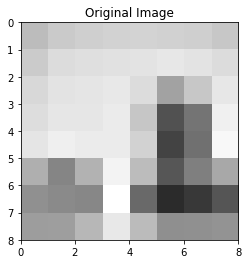

In [3]:
def plot_image_8x8(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 8, 8, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image_8x8(np_test_image_8x8, "Original Image")   

[[0.12184001 0.1309132  0.13415363 0.13609788 0.13739405 0.1354498
  0.13415363 0.12896894]
 [0.13156128 0.14257873 0.14452299 0.14581916 0.14776341 0.14970767
  0.14776341 0.14257873]
 [0.13998639 0.14776341 0.1484115  0.15035575 0.14257873 0.10498979
  0.12896894 0.14970767]
 [0.14322682 0.14905958 0.14905958 0.15230001 0.12832086 0.0524949
  0.07517788 0.15618852]
 [0.1484115  0.15554043 0.15230001 0.15230001 0.13609788 0.0434217
  0.07258554 0.16072512]
 [0.1134149  0.08619532 0.11535916 0.15813278 0.12184001 0.05573532
  0.08230681 0.1088783 ]
 [0.09332426 0.08943575 0.08749149 0.16526171 0.06869703 0.02786766
  0.03694085 0.05508724]
 [0.10174937 0.10239745 0.11859958 0.15035575 0.12119192 0.09267618
  0.09332426 0.0959166 ]]


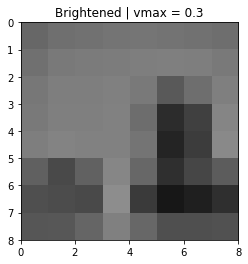

In [4]:
# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

def plot_image_8x8_bright(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 8, 8, 0], vmin=0, vmax=0.3, cmap='gray')
    plt.show()
    
np_test_image_8x8_normalized = normalize(np_test_image_8x8.reshape((1,64)))
np_test_image_8x8_normalized = np_test_image_8x8_normalized.reshape((8,8))

print(np_test_image_8x8_normalized)

plot_image_8x8_bright(np_test_image_8x8_normalized, "Brightened | vmax = 0.3")   

In [5]:
def ansatz_8x8(param, ansatz_num_layers):    
    num_q = 6
    qc = QuantumCircuit(num_q, num_q)    
    for ansatz_j in range(ansatz_num_layers):        
        for ansatz_i in range(num_q):
            qc.ry(param[ansatz_i + ansatz_j*num_q], ansatz_i)        
        if ansatz_j < ansatz_num_layers-1:            
            qc.cx(0,1)
            qc.cx(1,2)
            qc.cx(2,3)
            qc.cx(3,4)
            qc.cx(4,5)
            qc.cx(5,0)
            qc.barrier()
    qc.measure(range(num_q), range(num_q))      
    return qc

In [6]:
import math

def loss_function_8x8(params, loss_num_layers, loss_num_shots):
    # We will optimize this quantity as well
    num_shots = loss_num_shots
    circ = ansatz_8x8(param=params, ansatz_num_layers=loss_num_layers)
    counts = execute(circ, backend=simulator, shots=num_shots).result().get_counts(circ)
    
    strings = []
    for loss_i in range(2**6):
        strings.append(get_bin(loss_i,6))
    
    for loss_i in strings:
        if loss_i not in counts:
            counts[loss_i] = 0
    
    p = [counts[string]/num_shots for string in strings]
    for i_test in range(len(np_test_image_8x8_normalized)):
        if p[i_test] == 0:
            p[i_test] = 0.000001
    
    return sum([(p[loss_i] - np_test_image_8x8_normalized[loss_i])**2 for loss_i in range(len(np_test_image_8x8_normalized))])
    #return sum([abs(p[loss_i] - np_test_image_8x8_normalized[loss_i]) for loss_i in range(len(np_test_image_8x8_normalized))])
    #return sum([ np_test_image_8x8_normalized[loss_i]*math.log2(p[loss_i]) for loss_i in range(len(np_test_image_8x8_normalized))])

In [7]:
# Training the Quantum Circuit
import scipy.optimize as spo
np_test_image_8x8_normalized = np_test_image_8x8_normalized.reshape(64)

# Using SSIM
from skimage.metrics import structural_similarity as ssim

def un_normalize(true_image, true_image_normalized, image, n):
    perfect_image = true_image.reshape((n,n))
    normal_image = true_image_normalized.reshape((n,n))
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (normal_image[y][x] / perfect_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

# For Timing the learning 
import time

num_layers =  1
Beginning Training @  2022-12-10 20:44:50.177165
Finished Training @  2022-12-10 20:45:27.028286
Time Elapsed:  36.851126194000244 s.


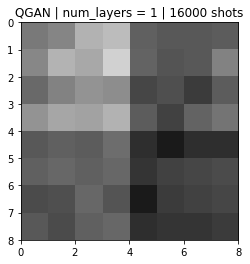

SSIM Error:  0.5268727240098214
-X-X-X-X-X-X-X-
num_layers =  2
Beginning Training @  2022-12-10 20:45:27.319725
Finished Training @  2022-12-10 20:46:46.313132
Time Elapsed:  78.99340987205505 s.


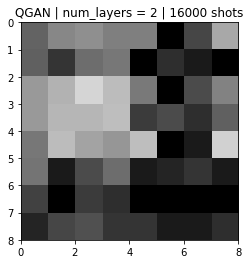

SSIM Error:  0.4842238655496545
-X-X-X-X-X-X-X-
num_layers =  3
Beginning Training @  2022-12-10 20:46:46.490064
Finished Training @  2022-12-10 20:48:56.330704
Time Elapsed:  129.84064316749573 s.


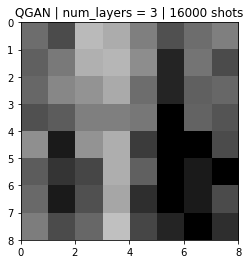

SSIM Error:  0.6269738956229483
-X-X-X-X-X-X-X-
num_layers =  4
Beginning Training @  2022-12-10 20:48:56.477940
Finished Training @  2022-12-10 20:52:19.932657
Time Elapsed:  203.45471811294556 s.


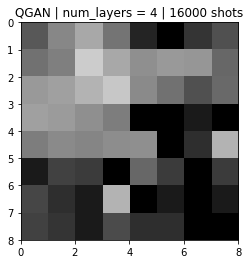

SSIM Error:  0.5640549365183032
-X-X-X-X-X-X-X-
num_layers =  5
Beginning Training @  2022-12-10 20:52:20.092293
Finished Training @  2022-12-10 20:57:06.641678
Time Elapsed:  286.54938292503357 s.


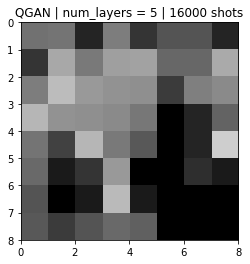

SSIM Error:  0.6713979040165494
-X-X-X-X-X-X-X-
num_layers =  6
Beginning Training @  2022-12-10 20:57:06.804601
Finished Training @  2022-12-10 21:03:28.507351
Time Elapsed:  381.70275473594666 s.


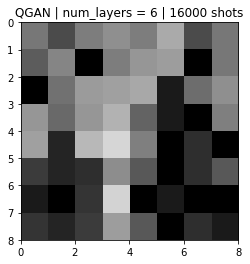

SSIM Error:  0.5578841254492063
-X-X-X-X-X-X-X-
num_layers =  7
Beginning Training @  2022-12-10 21:03:28.721797
Finished Training @  2022-12-10 21:11:15.776602
Time Elapsed:  467.0547981262207 s.


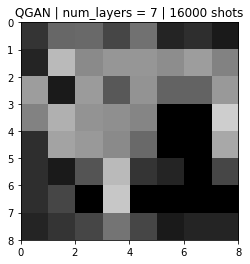

SSIM Error:  0.6615075188095675
-X-X-X-X-X-X-X-
num_layers =  8
Beginning Training @  2022-12-10 21:11:15.950020
Finished Training @  2022-12-10 21:21:54.244907
Time Elapsed:  638.2948899269104 s.


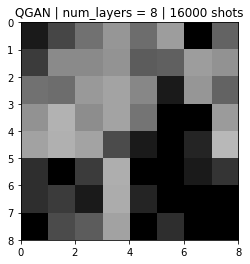

SSIM Error:  0.6424996954837907
-X-X-X-X-X-X-X-
num_layers =  9
Beginning Training @  2022-12-10 21:21:54.429107
Finished Training @  2022-12-10 21:35:05.893738
Time Elapsed:  791.4646308422089 s.


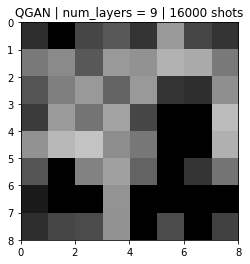

SSIM Error:  0.6644970902867554
-X-X-X-X-X-X-X-
num_layers =  10
Beginning Training @  2022-12-10 21:35:06.083431


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [ ]:
import datetime

# Here goes!
num_layers_array = [1,2,3,4,5,6,7,8,9,10]
num_shots_array = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

# Setting up the simulator:
simulator = Aer.get_backend('aer_simulator')
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

#Let's see how number of layers affects the image output
num_layers_qGAN_output = []
num_layers_SSIM_error = []
for num_layers_value in num_layers_array:
    print("num_layers = ", num_layers_value)
    # Define and Train the QGAN
    start_time = time.time()
    print("Beginning Training @ ", (datetime.datetime.now() + datetime.timedelta(hours=5.5)))
    minim_kwargs = {"method":"COBYLA", "args":(num_layers_value, 16000)}
    res = spo.basinhopping(loss_function_8x8, np.ones(6 * num_layers_value), minimizer_kwargs=minim_kwargs, niter=10)    
    #res = spo.minimize(loss_function_8x8, np.ones(6 * num_layers_value), args=(num_layers_value, 64000), method="COBYLA")
    end_time = time.time()
    print("Finished Training @ ", (datetime.datetime.now() + datetime.timedelta(hours=5.5)))
    print("Time Elapsed: ", (end_time - start_time), "s.")
    optimized_params = res.x
    trained_ansatz = ansatz_8x8(optimized_params, num_layers_value)
    
    # Run the QGAN
    trained_ansatz_transpiled = transpile(trained_ansatz, simulator)
    result = simulator.run(trained_ansatz_transpiled).result()
    counts = result.get_counts()
    
    # Construct the image from QGAN circuit output
    qGAN_output = []
    for i in range(64):
        if get_bin(i, 6) in counts:
            qGAN_output.append(np.sqrt( ( counts.get(get_bin(i, 6)) / 16000 ) ) )
        else:
            qGAN_output.append(0)
        
    np_qGAN_output = np.array(qGAN_output).reshape((8,8))
    np_qGAN_output = normalize(np_qGAN_output)
    
    num_layers_qGAN_output.append(np_qGAN_output)
    
    # Print image output
    title_string = "QGAN | num_layers = {} | 16000 shots".format(num_layers_value)
    plot_image_8x8_bright(np_qGAN_output, title_string)
    
    np_qGAN_output_unnormalized = un_normalize(np_test_image_8x8, np_test_image_8x8_normalized, np_qGAN_output, 8)
    ssim_error = ssim(np_test_image_8x8, np_qGAN_output_unnormalized, data_range=np_qGAN_output_unnormalized.max() - np_qGAN_output_unnormalized.min() )
    print("SSIM Error: ", ssim_error)
    num_layers_SSIM_error.append(ssim_error)
    
    print("-X-X-X-X-X-X-X-")
    

In [14]:
# Now, let's modify the loss function to optimize for SSIM:
import math

def loss_function_8x8_ssim(params, loss_num_layers, loss_num_shots):
    # We will optimize this quantity as well
    num_shots = loss_num_shots
    circ = ansatz_8x8(param=params, ansatz_num_layers=loss_num_layers)
    counts = execute(circ, backend=simulator, shots=num_shots).result().get_counts(circ)
    
    strings = []
    for loss_i in range(2**6):
        strings.append(get_bin(loss_i,6))
    
    for loss_i in strings:
        if loss_i not in counts:
            counts[loss_i] = 0
    
    p = [counts[string]/num_shots for string in strings]
    p = np.array(p).reshape((8,8))
    
    ssim_value =  ssim(np_test_image_8x8_normalized.reshape((8,8)), p, data_range=p.max() - p.min())
    
    return (ssim_value - 1.0)**2
    
    
    #return sum([(p[loss_i] - np_test_image_8x8_normalized[loss_i])**2 for loss_i in range(len(np_test_image_8x8_normalized))])
    #return sum([abs(p[loss_i] - np_test_image_8x8_normalized[loss_i]) for loss_i in range(len(np_test_image_8x8_normalized))])
    #return sum([ np_test_image_8x8_normalized[loss_i]*math.log2(p[loss_i]) for loss_i in range(len(np_test_image_8x8_normalized))])

num_layers =  1
Beginning Training @  2022-12-10 22:13:02.016454
Finished Training @  2022-12-10 22:13:36.258766
Time Elapsed:  34.24230885505676 s.


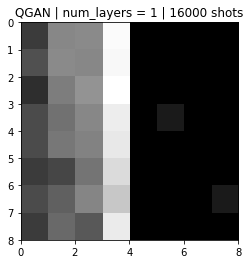

SSIM Error:  0.3089717259858365
-X-X-X-X-X-X-X-
num_layers =  2
Beginning Training @  2022-12-10 22:13:36.396966
Finished Training @  2022-12-10 22:14:55.208990
Time Elapsed:  78.81202006340027 s.


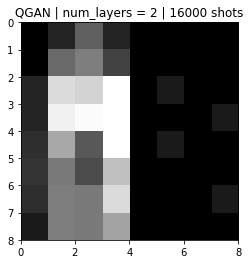

SSIM Error:  0.27489316054169793
-X-X-X-X-X-X-X-
num_layers =  3
Beginning Training @  2022-12-10 22:14:55.385608
Finished Training @  2022-12-10 22:17:21.592825
Time Elapsed:  146.2072160243988 s.


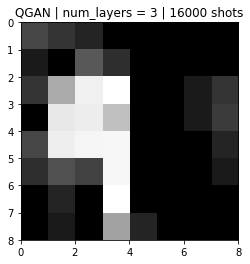

SSIM Error:  0.2991490784380826
-X-X-X-X-X-X-X-
num_layers =  4
Beginning Training @  2022-12-10 22:17:21.785934
Finished Training @  2022-12-10 22:20:38.582070
Time Elapsed:  196.7961344718933 s.


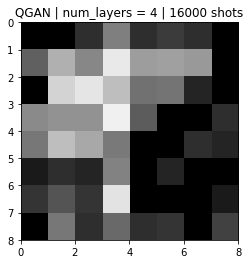

SSIM Error:  0.4713232148241195
-X-X-X-X-X-X-X-
num_layers =  5
Beginning Training @  2022-12-10 22:20:38.743450
Finished Training @  2022-12-10 22:25:46.834038
Time Elapsed:  308.0905849933624 s.


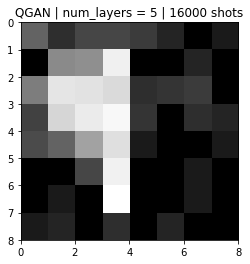

SSIM Error:  0.3620316248784029
-X-X-X-X-X-X-X-
num_layers =  6
Beginning Training @  2022-12-10 22:25:47.002545
Finished Training @  2022-12-10 22:32:14.289876
Time Elapsed:  387.28732919692993 s.


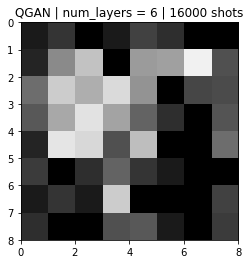

SSIM Error:  0.4734154237209783
-X-X-X-X-X-X-X-
num_layers =  7
Beginning Training @  2022-12-10 22:32:14.463766
Finished Training @  2022-12-10 22:40:59.541847
Time Elapsed:  525.0780813694 s.


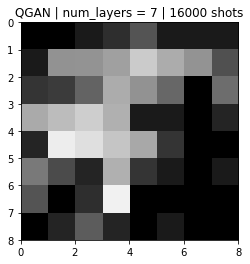

SSIM Error:  0.4663671509303675
-X-X-X-X-X-X-X-
num_layers =  8
Beginning Training @  2022-12-10 22:40:59.718634
Finished Training @  2022-12-10 22:51:42.493507
Time Elapsed:  642.7748684883118 s.


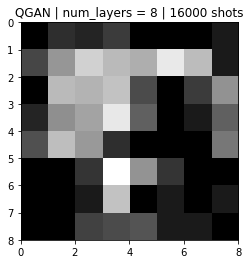

SSIM Error:  0.45956911012558094
-X-X-X-X-X-X-X-
num_layers =  9
Beginning Training @  2022-12-10 22:51:42.680313
Finished Training @  2022-12-10 23:06:06.162171
Time Elapsed:  863.4818584918976 s.


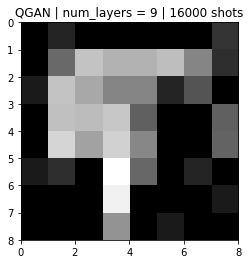

SSIM Error:  0.46291604615412085
-X-X-X-X-X-X-X-
num_layers =  10
Beginning Training @  2022-12-10 23:06:06.354004
Finished Training @  2022-12-10 23:22:31.384556
Time Elapsed:  985.0305559635162 s.


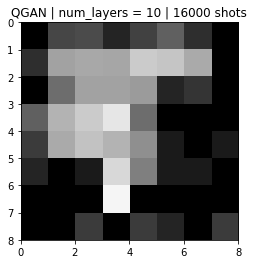

SSIM Error:  0.4883463920104088
-X-X-X-X-X-X-X-


In [15]:
import datetime

# Here goes!
num_layers_array = [1,2,3,4,5,6,7,8,9,10]
num_shots_array = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

# Setting up the simulator:
simulator = Aer.get_backend('aer_simulator')
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

#Let's see how number of layers affects the image output
num_layers_qGAN_output = []
num_layers_SSIM_error = []
for num_layers_value in num_layers_array:
    print("num_layers = ", num_layers_value)
    # Define and Train the QGAN
    start_time = time.time()
    print("Beginning Training @ ", (datetime.datetime.now() + datetime.timedelta(hours=5.5)))
    minim_kwargs = {"method":"COBYLA", "args":(num_layers_value, 16000)}
    res = spo.basinhopping(loss_function_8x8_ssim, np.ones(6 * num_layers_value), minimizer_kwargs=minim_kwargs, niter=10)    
    #res = spo.minimize(loss_function_8x8, np.ones(6 * num_layers_value), args=(num_layers_value, 64000), method="COBYLA")
    end_time = time.time()
    print("Finished Training @ ", (datetime.datetime.now() + datetime.timedelta(hours=5.5)))
    print("Time Elapsed: ", (end_time - start_time), "s.")
    optimized_params = res.x
    trained_ansatz = ansatz_8x8(optimized_params, num_layers_value)
    
    # Run the QGAN
    trained_ansatz_transpiled = transpile(trained_ansatz, simulator)
    result = simulator.run(trained_ansatz_transpiled).result()
    counts = result.get_counts()
    
    # Construct the image from QGAN circuit output
    qGAN_output = []
    for i in range(64):
        if get_bin(i, 6) in counts:
            qGAN_output.append(np.sqrt( ( counts.get(get_bin(i, 6)) / 16000 ) ) )
        else:
            qGAN_output.append(0)
        
    np_qGAN_output = np.array(qGAN_output).reshape((8,8))
    np_qGAN_output = normalize(np_qGAN_output)
    
    num_layers_qGAN_output.append(np_qGAN_output)
    
    # Print image output
    title_string = "QGAN | num_layers = {} | 16000 shots".format(num_layers_value)
    plot_image_8x8_bright(np_qGAN_output, title_string)
    
    np_qGAN_output_unnormalized = un_normalize(np_test_image_8x8, np_test_image_8x8_normalized, np_qGAN_output, 8)
    ssim_error = ssim(np_test_image_8x8, np_qGAN_output_unnormalized, data_range=np_qGAN_output_unnormalized.max() - np_qGAN_output_unnormalized.min() )
    print("SSIM Error: ", ssim_error)
    num_layers_SSIM_error.append(ssim_error)
    
    print("-X-X-X-X-X-X-X-")
    

[]
num_layers =  1
Beginning Training @  2022-12-11 00:14:50.596802
Starting Params: 
[1. 1. 1. 1. 1. 1.]
Finished Training @  2022-12-11 00:15:24.969736
Time Elapsed:  34.37293338775635 s.
Ending Params: 
[1.81120387 1.86791676 1.0692143  1.5659859  1.40764769 1.16687444]


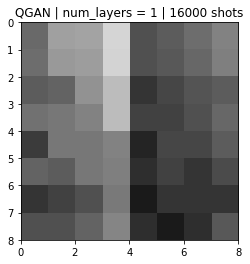

SSIM Error:  0.5618539020428285
-X-X-X-X-X-X-X-
num_layers =  2
Beginning Training @  2022-12-11 00:15:25.140095
Starting Params: 
[1.81120387 1.86791676 1.0692143  1.5659859  1.40764769 1.16687444
 1.         1.         1.         1.         1.         1.        ]
Finished Training @  2022-12-11 00:16:45.108208
Time Elapsed:  79.96810913085938 s.
Ending Params: 
[2.75104775 3.04798765 0.21738893 2.55763326 3.99730387 0.83711857
 1.57400251 1.80485059 0.90952097 1.19823526 2.10184007 0.05732787]


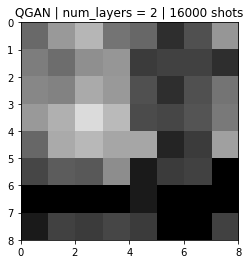

SSIM Error:  0.5203782943627644
-X-X-X-X-X-X-X-
num_layers =  3
Beginning Training @  2022-12-11 00:16:45.248734
Starting Params: 
[2.75104775 3.04798765 0.21738893 2.55763326 3.99730387 0.83711857
 1.57400251 1.80485059 0.90952097 1.19823526 2.10184007 0.05732787
 1.         1.         1.         1.         1.         1.        ]
Finished Training @  2022-12-11 00:19:07.873985
Time Elapsed:  142.625248670578 s.
Ending Params: 
[ 3.58519293  2.10612343 -0.01558654  4.87862592  4.66316968 -0.99481873
  2.74759269  4.87234483  0.78228183  2.50778225  1.34446099 -0.99352865
  1.94343687  3.41947142  0.77115301  1.27023444  2.77506476 -0.24851265]


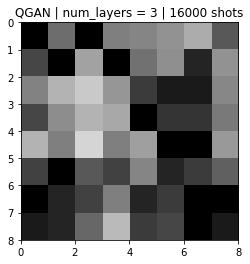

SSIM Error:  0.48485204376183294
-X-X-X-X-X-X-X-
num_layers =  4
Beginning Training @  2022-12-11 00:19:08.024319
Starting Params: 
[ 3.58519293  2.10612343 -0.01558654  4.87862592  4.66316968 -0.99481873
  2.74759269  4.87234483  0.78228183  2.50778225  1.34446099 -0.99352865
  1.94343687  3.41947142  0.77115301  1.27023444  2.77506476 -0.24851265
  1.          1.          1.          1.          1.          1.        ]
Finished Training @  2022-12-11 00:22:26.296410
Time Elapsed:  198.2720923423767 s.
Ending Params: 
[ 5.45199479  2.65439152 -0.13943068 11.38924089  7.83811457 -0.09350075
  3.73277787  9.8535935   1.85001868  4.42701139  2.77455014 -2.51333928
  2.26186816  2.04173755  2.47597583  0.82176645  3.85788786 -0.2817571
 -1.46260372  2.30059078  1.13517927  1.18441007  2.27205536  0.38481613]


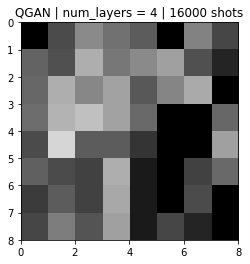

SSIM Error:  0.5819016636022074
-X-X-X-X-X-X-X-
num_layers =  5
Beginning Training @  2022-12-11 00:22:26.450062
Starting Params: 
[ 5.45199479  2.65439152 -0.13943068 11.38924089  7.83811457 -0.09350075
  3.73277787  9.8535935   1.85001868  4.42701139  2.77455014 -2.51333928
  2.26186816  2.04173755  2.47597583  0.82176645  3.85788786 -0.2817571
 -1.46260372  2.30059078  1.13517927  1.18441007  2.27205536  0.38481613
  1.          1.          1.          1.          1.          1.        ]
Finished Training @  2022-12-11 00:27:19.084239
Time Elapsed:  292.63418197631836 s.
Ending Params: 
[ 6.08184988  3.7852608   1.92441396 14.42847021  9.32877245  0.07842318
  5.86372838  9.61037823  2.31292832  4.15906159  2.45445296 -2.61818488
  3.26613924  1.78293165  3.44247451 -0.09324082  5.26760699 -2.28254525
 -1.4355741   1.49819146  1.64431639  2.26529547  1.95379272  0.18107877
  0.84926491  1.14165917  1.10384356  1.12803329  1.15070479  0.71008817]


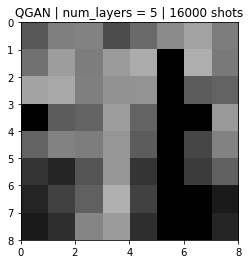

SSIM Error:  0.6503297094217508
-X-X-X-X-X-X-X-
num_layers =  6
Beginning Training @  2022-12-11 00:27:19.279037
Starting Params: 
[ 6.08184988  3.7852608   1.92441396 14.42847021  9.32877245  0.07842318
  5.86372838  9.61037823  2.31292832  4.15906159  2.45445296 -2.61818488
  3.26613924  1.78293165  3.44247451 -0.09324082  5.26760699 -2.28254525
 -1.4355741   1.49819146  1.64431639  2.26529547  1.95379272  0.18107877
  0.84926491  1.14165917  1.10384356  1.12803329  1.15070479  0.71008817
  1.          1.          1.          1.          1.          1.        ]
Finished Training @  2022-12-11 00:33:42.768907
Time Elapsed:  383.4899046421051 s.
Ending Params: 
[ 8.9157213   5.71183219  3.19576217 17.24882602 10.12655088  1.65875069
  6.95902471  9.48181767  3.64034309  3.94666178  1.53553485 -2.13152888
  4.48046992  3.72748829  3.38540368  1.7531457   7.05718234 -2.12885217
 -2.05479876  4.07245717  1.81327619  3.23611021  2.29722019  2.21334476
  2.9383092   1.05240293  0.24154746  

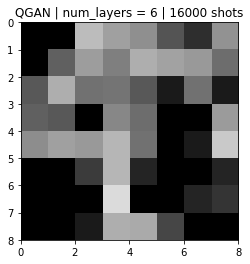

SSIM Error:  0.5585440188637635
-X-X-X-X-X-X-X-
num_layers =  7
Beginning Training @  2022-12-11 00:33:42.938342
Starting Params: 
[ 8.9157213   5.71183219  3.19576217 17.24882602 10.12655088  1.65875069
  6.95902471  9.48181767  3.64034309  3.94666178  1.53553485 -2.13152888
  4.48046992  3.72748829  3.38540368  1.7531457   7.05718234 -2.12885217
 -2.05479876  4.07245717  1.81327619  3.23611021  2.29722019  2.21334476
  2.9383092   1.05240293  0.24154746  1.22051864 -0.1702676   2.41039119
  0.41747539  0.59708411  2.27066345  1.64836104  2.73105192 -0.09491008
  1.          1.          1.          1.          1.          1.        ]


In [ ]:
# Quick modification to see if we can speed up training a little bit
import datetime

# Here goes!
num_layers_array = [1, 2, 3, 4, 5, 6, 7, 8, 9]
num_shots_array = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

# Setting up the simulator:
simulator = Aer.get_backend('aer_simulator')
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

previous_iteration_params = []
previous_iteration_params = np.array(previous_iteration_params)
print(previous_iteration_params)

#Let's see how number of layers affects the image output
num_layers_qGAN_output = []
num_layers_SSIM_error = []
for num_layers_value in num_layers_array:
    print("num_layers = ", num_layers_value)
    # Define and Train the QGAN
    start_time = time.time()
    print("Beginning Training @ ", (datetime.datetime.now() + datetime.timedelta(hours=5.5)))
    minim_kwargs = {"method":"COBYLA", "args":(num_layers_value, 16000)}
    new_params = np.concatenate((previous_iteration_params, np.ones(6)))
    print("Starting Params: ")
    print(new_params)
    res = spo.basinhopping(loss_function_8x8, new_params, minimizer_kwargs=minim_kwargs, niter=10)    
    end_time = time.time()
    print("Finished Training @ ", (datetime.datetime.now() + datetime.timedelta(hours=5.5)))
    print("Time Elapsed: ", (end_time - start_time), "s.")
    optimized_params = res.x
    previous_iteration_params = optimized_params
    print("Ending Params: ")
    print(optimized_params)
    trained_ansatz = ansatz_8x8(optimized_params, num_layers_value)
    
    # Run the QGAN
    trained_ansatz_transpiled = transpile(trained_ansatz, simulator)
    result = simulator.run(trained_ansatz_transpiled).result()
    counts = result.get_counts()
    
    # Construct the image from QGAN circuit output
    qGAN_output = []
    for i in range(64):
        if get_bin(i, 6) in counts:
            qGAN_output.append(np.sqrt( ( counts.get(get_bin(i, 6)) / 16000 ) ) )
        else:
            qGAN_output.append(0)
        
    np_qGAN_output = np.array(qGAN_output).reshape((8,8))
    np_qGAN_output = normalize(np_qGAN_output)
    
    num_layers_qGAN_output.append(np_qGAN_output)
    
    # Print image output
    title_string = "QGAN | num_layers = {} | 16000 shots".format(num_layers_value)
    plot_image_8x8_bright(np_qGAN_output, title_string)
    
    np_qGAN_output_unnormalized = un_normalize(np_test_image_8x8, np_test_image_8x8_normalized, np_qGAN_output, 8)
    ssim_error = ssim(np_test_image_8x8, np_qGAN_output_unnormalized, data_range=np_qGAN_output_unnormalized.max() - np_qGAN_output_unnormalized.min() )
    print("SSIM Error: ", ssim_error)
    num_layers_SSIM_error.append(ssim_error)
    
    print("-X-X-X-X-X-X-X-")
    

In [26]:
np_arr_1 = [4.231, 0.232, 21.12211]
np_arr_2 = np.ones(3)
print(np_arr_1)
print(np_arr_2)
print(np.concatenate((np_arr_1, np_arr_2)))

[4.231, 0.232, 21.12211]
[1. 1. 1.]
[ 4.231    0.232   21.12211  1.       1.       1.     ]
